# Statistical analysis

In [ ]:
import sys
sys.path.append(r"C:/Users/Matthieu/Documents/_Travail/Stages/Stage M1/Workspace/cooperation_emergence/")

from utils import parse_parameters, print_parameters, list_all_hdf5
from graph import Network
from analysis import measure, measure_individual_asymmetry, compute_xhi_mean, compute_xhi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py

import pymc as pm
import arviz as az
import xarray as xr

c:\Users\Matthieu\Documents\_Travail\Stages\Stage M1\Workspace\cooperation_emergence\graph.py:223: SyntaxWarning: invalid escape sequence '\i'
  and S \in [0, 10]


In [2]:
# Setup
N = 100 # Statistical number
base_parameters = parse_parameters("./out/statistical/parameters.yaml")
out_dir = base_parameters["Output directory"]
print_parameters(base_parameters)

.. Cognitive capacity :  750
.. Community size :  75
.. Heuristic :  RTH
.. Init :  Empty
.. Link minimum :  10
.. Number of interaction :  600000
.. Output directory :  ./out/statistical/
.. Save mode :  Last
.. Strategy distributions :  {'Envious': 0.3, 'Optimist': 0.2, 'Pessimist': 0.21, 'Random': 0.12, 'Trustful': 0.17}
.. Temperature :  0.25
.. Verbose :  False


### Launching simulation

In [ ]:
# Running simuations
net = Network(base_parameters)
saturation_rate = np.zeros(N)
global_asymmetry = np.zeros(N)
individual_asymmetry = np.zeros(N)
for seed in tqdm(range(N)):
    net.reset(base_parameters, new_seed=seed)
    net.play()
    t, l = net.get_adjacency_trust_matrix(), net.get_adjacency_link_matrix()
    saturation_rate[seed] = measure("Saturation rate", t, l, base_parameters)
    global_asymmetry[seed] = measure("Asymmetry", t, l, base_parameters)
    individual_asymmetry[seed] = measure("Individual asymmetry", t, l, base_parameters)

In [4]:
print("Saving in: ", out_dir)
datas = {
    "Saturation rate": saturation_rate,
    "Global asymmetry": global_asymmetry,
    "Individual asymmetry": individual_asymmetry 
}
df = pd.DataFrame(datas)
df.to_csv(out_dir + "stats.csv")

Saving in:  ./out/statistical/


## Analysing

### Csv loading

In [5]:
# Retrieving data
print("Opening: ", out_dir)
df = pd.read_csv(out_dir + "stats.csv")
saturation_rate = df["Saturation rate"]
global_asymmetry = df["Global asymmetry"]
individual_asymmetry = df["Individual asymmetry"]

Opening:  ./out/statistical/


### HDF5 Loading

In [6]:
# Getting back all hdf5 files
files = list_all_hdf5(out_dir)

In [7]:
size = base_parameters["Community size"]
full_individual_asymmetry = np.zeros((size, N))
randomized_individual_asymmetry = np.zeros(N)
for i in range(N):
    h = h5py.File(files[i])
    t = h.get("Trust")
    l = h.get("Link")
    data = measure_individual_asymmetry(l, full=True)
    randomized_individual_asymmetry[i] = measure("Individual asymmetry", t, l, base_parameters, random=True, mode="o")
    for j in range(size):
        full_individual_asymmetry[j, i] = data[j]

### Analysis

In [8]:
print("Saturation rate:", np.mean(saturation_rate), "+-",  np.std(saturation_rate, ddof=N-1)/2)
print("Global asymmetry:", np.mean(global_asymmetry), "+-",  np.std(global_asymmetry, ddof=N-1)/2)
print("Individual asymmetry:", np.mean(individual_asymmetry), "+-",  np.std(individual_asymmetry, ddof=N-1)/2)

Saturation rate: 0.8796 +- 0.21196540598251712
Global asymmetry: 0.5989037013272088 +- 0.05541245902086627
Individual asymmetry: 0.4732197098477418 +- 0.10918515261764149


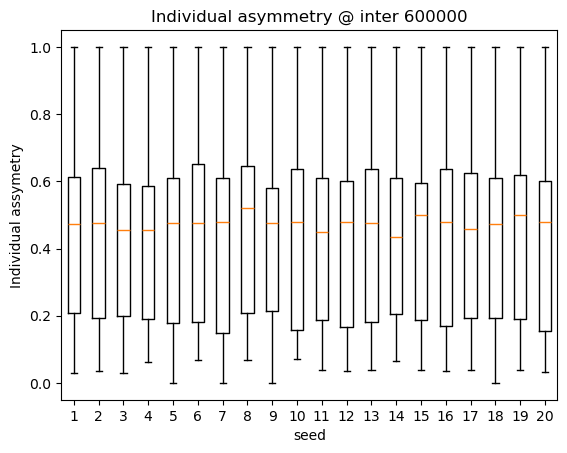

In [9]:
plt.boxplot(full_individual_asymmetry[:, :20])
plt.title("Individual asymmetry @ inter {}".format(base_parameters["Number of interaction"]))
plt.xlabel("seed")
plt.ylabel("Individual assymetry")
#plt.xticks(np.arange(0, 200, 20), np.arange(0, 200, 20))
plt.savefig("./plot/statistical_ind_asymmetry_boxplot.png")
plt.show()

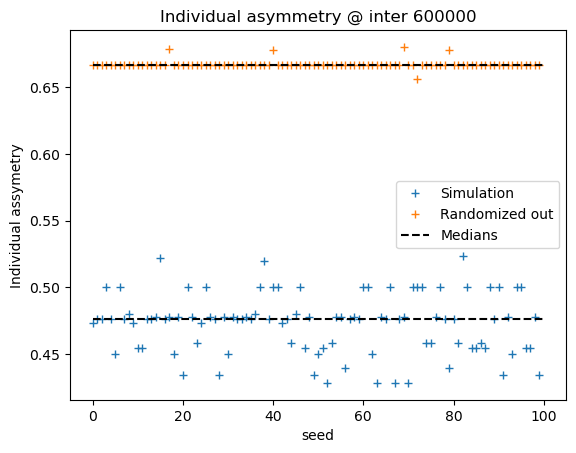

In [11]:
plt.plot(individual_asymmetry, "+", label="Simulation")
plt.plot(randomized_individual_asymmetry, "+", label="Randomized out")
plt.hlines([np.median(individual_asymmetry), np.median(randomized_individual_asymmetry)], 0, 100, colors="k", linestyles="dashed", label="Medians")
plt.title("Individual asymmetry @ inter {}".format(base_parameters["Number of interaction"]))
plt.xlabel("seed")
plt.ylabel("Individual assymetry")
plt.legend()
#plt.savefig("./plot/statistical_median_ind_asymmetry.png")
plt.show()

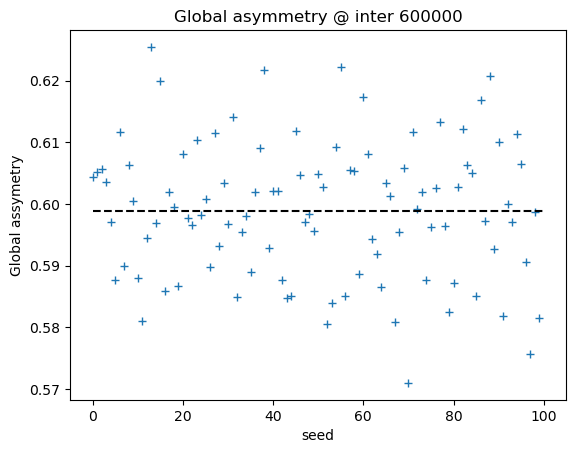

In [12]:
plt.plot(global_asymmetry, '+')
plt.hlines(np.mean(global_asymmetry), 0, 100, colors="k", linestyles="dashed")
plt.title("Global asymmetry @ inter {}".format(base_parameters["Number of interaction"]))
plt.xlabel("seed")
plt.ylabel("Global assymetry")
plt.show()

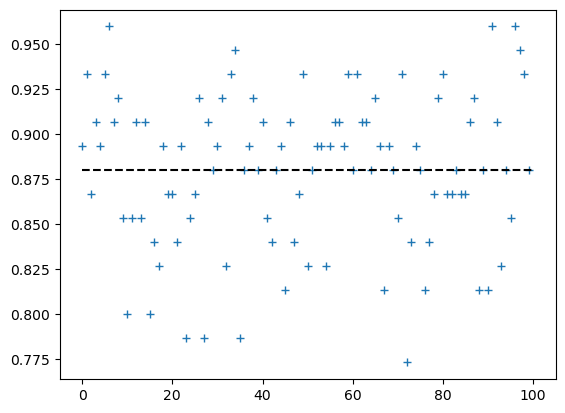

In [13]:
plt.plot(saturation_rate, "+")
plt.hlines(np.median(saturation_rate), 0, 100, colors="k", linestyles="dashed")
plt.show()

#### Analysis of the $\chi$ s

In [24]:
agent = 0

xhi_mean = []
t_norm = []

for i in range(N):
    h = h5py.File(files[i])
    t = h.get("Trust")
    xhi_mean_i = compute_xhi_mean(t, base_parameters)
    sizei = xhi_mean_i.size
    t_norm_i = np.arange(sizei)/(sizei-1)
    for j in range(sizei):
        t_norm.append(t_norm_i[j])
        xhi_mean.append(xhi_mean_i[j])
print(sizei)

xhi_mean = np.array(xhi_mean)
t_norm = np.array(t_norm)

89


In [ ]:
with pm.Model() as model:
    # Priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    etas = pm.Normal("etas", mu=2, sigma=4)

    func_model = lambda eta, t: (np.exp(eta * t) - 1) / (np.exp(eta) - 1)
    # Likelihood
    likelihood = pm.Normal("xhi mean", mu=func_model(etas, t_norm), sigma=sigma, observed=xhi_mean)
    # Inference
    idata = pm.sample(3000, progressbar=False)
az.plot_trace(idata, figsize=(10, 7))

Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'etas': array(1.62946624)}

Logp initial evaluation results:
{'etas': -2.31, 'xhi mean': -inf}
You can call `model.debug()` for more details.

In [16]:
az.summary(idata, kind="all", round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
etas,3.9905,0.0072,3.9773,4.0044,0.0001,0.0001,12385.2845,9152.0836,1.0003
sigma,0.0342,0.0003,0.0337,0.0347,0.0000,0.0000,12626.5955,9241.6549,0.9999


In [17]:
t_base = np.linspace(0, 1, 500)
idata.posterior["model"] = (np.exp(idata.posterior["etas"] * xr.DataArray(t_norm)) - 1) / (np.exp(idata.posterior["etas"]) - 1)

In [18]:
pp = pm.sample_posterior_predictive(idata, model, progressbar=False)
idata.extend(pp)

Sampling: [xhi mean]


array([[<Axes: ylabel='xhi mean'>]], dtype=object)

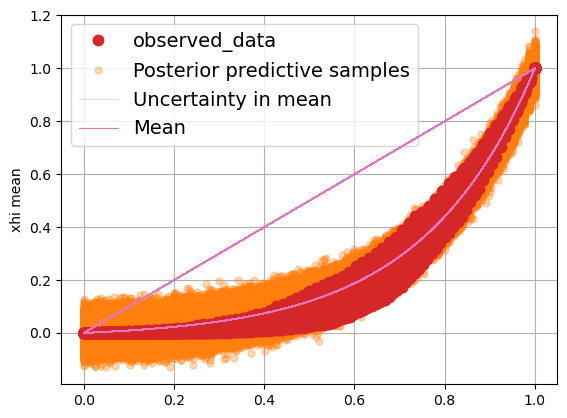

In [19]:
az.plot_lm("xhi mean", idata, t_norm, "model")

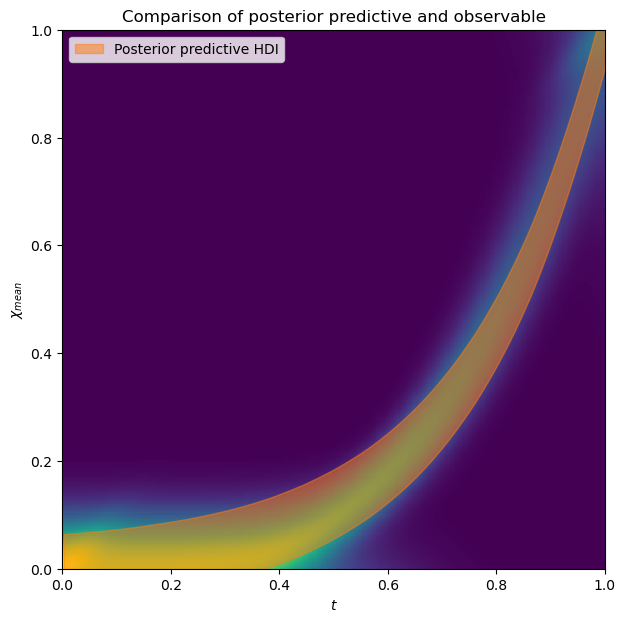

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
az.plot_kde(t_norm, xhi_mean, contour=False, ax=ax, label="Observed data KDE", fill_kwargs={"alpha": 0.1})
az.plot_hdi(t_norm, idata.posterior_predictive["xhi mean"], fill_kwargs={"label": "Posterior predictive HDI"})
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_xlabel("$t$")
ax.set_ylabel("$\\chi_{mean}$")
ax.set_title("Comparison of posterior predictive and observable")
plt.legend()
plt.show()

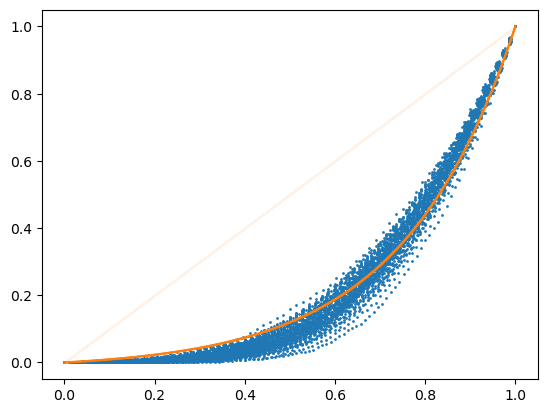

In [28]:
plt.scatter(t_norm, xhi_mean, s=1, color="tab:blue")
func_model = lambda eta, t: (np.exp(eta * t) - 1) / (np.exp(eta) - 1)
t = t_norm[len(t_norm) - sizei::]
plt.plot(t, func_model(3.9773, t), color="tab:orange")
plt.plot(t, func_model(4.0044, t), color="tab:orange")
plt.fill_between(t_norm, func_model(4.0044, t_norm), func_model(3.9773, t_norm), color="tab:orange", alpha=0.1)